<font size=5>Convolutional Neural Networks: Step by Step——一步一步构建卷积神经网络

In [52]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)  # 设置默认的绘图尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)  # 设置随机种子，确保生成的随机数可重复

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<img src="https://raw.githubusercontent.com/robbertliu/deeplearning.ai-andrewNG/b18a671f605951642c7f450181e5764ce56b7048/COURSE%204%20Convolutional%20Neural%20Networks/Week%2001/images/model.png" width="50%" height="50%">

<img src="https://raw.githubusercontent.com/robbertliu/deeplearning.ai-andrewNG/b18a671f605951642c7f450181e5764ce56b7048/COURSE%204%20Convolutional%20Neural%20Networks/Week%2001/images/conv_nn.png" width="30%" height="30%">

In [36]:
def zero_pad(X, pad):
    """
    在图像数据集X的所有图像周围填充零。填充应用于图像的高度和宽度.
    
    参数：
    X -- 形状为(m, n_H, n_W, n_C)的Python numpy数组，表示m个图像的批处理
    pad -- 整数，表示在每个图像的垂直和水平维度周围填充的数量
    
    返回：
    X_pad -- 形状为(m, n_H + 2*pad, n_W + 2*pad, n_C)的填充图像
    """
    
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), "constant")
    
    return X_pad


<img src="https://raw.githubusercontent.com/robbertliu/deeplearning.ai-andrewNG/b18a671f605951642c7f450181e5764ce56b7048/COURSE%204%20Convolutional%20Neural%20Networks/Week%2001/images/PAD.png" width="50%" height="50%">

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


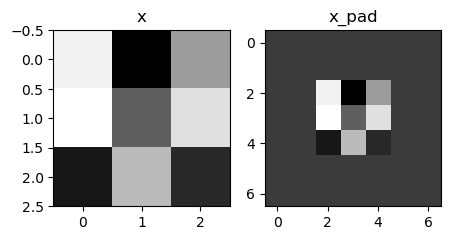

In [37]:
np.random.seed(1)  # 设置随机种子，保证结果可复现
x = np.random.randn(4, 3, 3, 2)  # 创建一个随机数组，形状为 (4, 3, 3, 2)
x_pad = zero_pad(x, 2)  # 对数组进行零填充，填充大小为 2
print ("x.shape =", x.shape)  # 打印原始数组 x 的形状
print ("x_pad.shape =", x_pad.shape)  # 打印零填充后的数组 x_pad 的形状
print ("x[1,1] =", x[1,1])  # 打印原始数组 x 中索引为 (1, 1) 的元素
print ("x_pad[1,1] =", x_pad[1,1])  # 打印零填充后的数组 x_pad 中索引为 (1, 1) 的元素

fig, axarr = plt.subplots(1, 2)  # 创建一个包含两个子图的图像窗口
axarr[0].set_title('x')  # 设置子图 0 的标题为 'x'
axarr[0].imshow(x[0,:,:,0])  # 在子图 0 中绘制原始数组 x 的第一个通道
axarr[1].set_title('x_pad')  # 设置子图 1 的标题为 'x_pad'
axarr[1].imshow(x_pad[0,:,:,0])  # 在子图 1 中绘制零填充后的数组 x_pad 的第一个通道


In [38]:
def conv_single_step(a_slice_prev, W, b):
    """
    对前一层的输出激活的单个切片（a_slice_prev）应用由参数 W 定义的一个滤波器。
    
    参数：
    a_slice_prev -- 输入数据的切片，形状为 (f, f, n_C_prev)
    W -- 权重参数，窗口矩阵，形状为 (f, f, n_C_prev)
    b -- 偏置参数，窗口矩阵，形状为 (1, 1, 1)
    
    返回：
    Z -- 标量值，通过将滑动窗口 (W, b) 卷积到输入数据的切片上得到的结果
    """

    # a_slice_prev 和 W 逐元素相乘，不添加偏置。
    s = np.multiply(a_slice_prev, W)
    # 对 s 的所有元素求和。
    Z = np.sum(s)
    # 将偏置 b 加到 Z 上。将 b 转换为 float() 类型，使得 Z 成为标量值。
    Z = Z + float(b)

    return Z


<img src="https://raw.githubusercontent.com/robbertliu/deeplearning.ai-andrewNG/b18a671f605951642c7f450181e5764ce56b7048/COURSE%204%20Convolutional%20Neural%20Networks/Week%2001/images/Convolution_schematic.gif" height="40%" width="40%">

In [39]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


In [40]:
def conv_forward(A_prev, W, b, hparameters):
    """
    实现卷积函数的前向传播
    
    参数：
    A_prev -- 前一层的输出激活，numpy 数组，形状为 (m, n_H_prev, n_W_prev, n_C_prev)
    W -- 权重，numpy 数组，形状为 (f, f, n_C_prev, n_C)
    b -- 偏置，numpy 数组，形状为 (1, 1, 1, n_C)
    hparameters -- 包含 "stride" 和 "pad" 信息的 Python 字典
        
    返回：
    Z -- 卷积输出，numpy 数组，形状为 (m, n_H, n_W, n_C)
    cache -- 用于反向传播的值的缓存
    """
    
    # 从 A_prev 的形状中提取维度（≈1 行代码）  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # 从 W 的形状中提取维度（≈1 行代码）
    (f, f, n_C_prev, n_C) = W.shape
    
    # 从 "hparameters" 中获取信息（≈2 行代码）
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # 使用上述给定的公式计算 CONV 输出体积的维度。提示：使用 int() 进行向下取整。（≈2 行代码）
    n_H = (n_H_prev - f + 2 * pad) // stride + 1
    n_W = (n_W_prev - f + 2 * pad) // stride + 1
    
    # 使用零初始化输出体积 Z（≈1 行代码）
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # 通过对 A_prev 进行填充来创建 A_prev_pad
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                               # 遍历训练样本的批次
        a_prev_pad = A_prev_pad[i, :, :, :]                              # 选择第 i 个训练样本的填充激活
        for h in range(n_H):                           # 遍历输出体积的垂直轴
            for w in range(n_W):                       # 遍历输出体积的水平轴
                for c in range(n_C):                   # 遍历通道数（= #滤波器）的输出体积
                    
                    # 找到当前 "slice" 的角落坐标（≈4 行代码）
                    vert_start = h * stride
                    vert_end = vert_start + stride
                    horiz_start = w * stride
                    horiz_end = horiz_start + stride
                    
                    # 使用角落坐标来定义 a_prev_pad 的（3D）切片（参见上面的提示）。 （≈1 行代码）
                    a_slice_prev = a_prev_pad[vert_start : vert_end, horiz_start : horiz_end, : ]
                    
                    # 将（3D）切片与正确的滤波器 W 和偏置 b 进行卷积，得到一个输出神经元。 （≈1 行代码）
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:, :, :, c], b[:, :, :, c])
    
    # 确保输出的形状正确
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # 将值保存在 "cache" 中，以便进行反向传播
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache


<img src="https://raw.githubusercontent.com/robbertliu/deeplearning.ai-andrewNG/b18a671f605951642c7f450181e5764ce56b7048/COURSE%204%20Convolutional%20Neural%20Networks/Week%2001/images/vert_horiz_kiank.png" height="40%" width="40%">

In [41]:
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)  # 随机生成输入数据 A_prev，维度为 (m, n_H_prev, n_W_prev, n_C_prev)
W = np.random.randn(2, 2, 3, 8)  # 随机生成卷积核参数 W，维度为 (f, f, n_C_prev, n_C)
b = np.random.randn(1, 1, 1, 8)  # 随机生成偏置项参数 b，维度为 (1, 1, 1, n_C)
hparameters = {"pad": 2, "stride": 2}  # 设置填充和步幅参数

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)  # 执行前向传播计算卷积
print("Z 的均值 =", np.mean(Z))  # 输出 Z 的均值
print("Z[3,2,1] =", Z[3,2,1])  # 输出 Z 在指定位置的值
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])  # 输出 cache_conv 中的值


Z 的均值 = 0.048995203528855794
Z[3,2,1] = [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


In [42]:
# GRADED FUNCTION: pool_forward

def pool_forward(A_prev, hparameters, mode="max"):
    """
    实现池化层的前向传播
    
    参数：
    A_prev -- 输入数据，维度为 (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- 包含 "f" 和 "stride" 的 Python 字典
    mode -- 池化模式，字符串类型，可选 "max" 或 "average"
    
    返回：
    A -- 池化层的输出，维度为 (m, n_H, n_W, n_C)
    cache -- 在池化层反向传播中使用的缓存，包含输入数据和 hparameters
    """
    
    # 从输入形状中获取维度
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # 从 "hparameters" 中获取超参数
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # 定义输出的维度
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # 初始化输出矩阵 A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    ### START CODE HERE ###
    for i in range(m):                         # 遍历训练样本
        for h in range(n_H):                     # 遍历输出体积的垂直轴
            for w in range(n_W):                 # 遍历输出体积的水平轴
                for c in range(n_C):            # 遍历输出体积的通道
                    
                    # 找到当前 "slice" 的角落位置 (≈4 行)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # 使用角落位置在 A_prev 的第 i 个训练样本的第 c 个通道上定义当前切片 (≈1 行)
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # 根据不同的模式计算池化操作，使用 if 语句区分模式，使用 np.max/np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    ### END CODE HERE ###
    
    # 在 "cache" 中存储输入数据和 hparameters，用于池化层的反向传播
    cache = (A_prev, hparameters)
    
    # 确保输出形状正确
    assert A.shape == (m, n_H, n_W, n_C)
    
    return A, cache


In [43]:
# 设置随机种子
np.random.seed(1)
# 创建输入数据A_prev，大小为(2, 4, 4, 3)
A_prev = np.random.randn(2, 4, 4, 3)
# 设置池化层超参数，步长为2，过滤器大小为3
hparameters = {"stride": 2, "f": 3}

# 使用最大池化模式进行前向传播
A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()

# 使用平均池化模式进行前向传播
A, cache = pool_forward(A_prev, hparameters, mode="average")
print("mode = average")
print("A =", A)


mode = max
A = [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]

mode = average
A = [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


In [44]:
def conv_backward(dZ, cache):
    """
    实现卷积层的反向传播
    
    参数：
    dZ -- 损失函数相对于卷积层输出（Z）的梯度，形状为 (m, n_H, n_W, n_C) 的 numpy 数组
    cache -- 用于 conv_backward() 的值的缓存，是 conv_forward() 的输出
    
    返回值：
    dA_prev -- 损失函数相对于卷积层输入（A_prev）的梯度，形状为 (m, n_H_prev, n_W_prev, n_C_prev) 的 numpy 数组
    dW -- 损失函数相对于卷积层权重（W）的梯度，形状为 (f, f, n_C_prev, n_C) 的 numpy 数组
    db -- 损失函数相对于卷积层偏置（b）的梯度，形状为 (1, 1, 1, n_C) 的 numpy 数组
    """
    
    ### START CODE HERE ###
    # 从缓存中提取信息
    (A_prev, W, b, hparameters) = cache
    
    # 从 A_prev 的形状中提取维度
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # 从 W 的形状中提取维度
    (f, f, n_C_prev, n_C) = W.shape
    
    # 从 "hparameters" 中提取信息
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # 从 dZ 的形状中提取维度
    (m, n_H, n_W, n_C) = dZ.shape
    
    # 初始化 dA_prev, dW, db 的形状
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    # 对 A_prev 和 dA_prev 进行填充
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       # 遍历训练样本
        
        # 选择第 i 个训练样本的 A_prev_pad 和 dA_prev_pad
        a_prev_pad = A_prev_pad[i, :, :, :]
        da_prev_pad = dA_prev_pad[i, :, :, :]
        
        for h in range(n_H):                   # 遍历输出体积的垂直轴
            for w in range(n_W):               # 遍历输出体积的水平轴
                for c in range(n_C):           # 遍历输出体积的通道
                    
                    # 找到当前 "slice" 的角落坐标
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # 使用角落坐标定义来自 a_prev_pad 的切片
                    a_slice = a_prev_pad[vert_start : vert_end, horiz_start : horiz_end, :]

                    # 使用给定的代码公式更新窗口和滤波器参数的梯度
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # 将第 i 个训练样本的 dA_prev 设置为未填充的 da_prev_pad（提示：使用 X[pad:-pad, pad:-pad, :]）
        dA_prev[i, :, :, :] = da_prev_pad[pad : -pad, pad : -pad, :]
    ### END CODE HERE ###
    
    # 确保输出形状正确
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db


In [45]:
np.random.seed(1)  # 设置随机种子，保证随机结果可复现

# 调用 conv_backward 函数计算梯度
dA, dW, db = conv_backward(Z, cache_conv)

# 打印 dA、dW、db 的平均值
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))


dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838


In [46]:
def create_mask_from_window(x):
    """
    从输入矩阵 x 创建一个掩码，以识别 x 中的最大值位置。
    
    参数：
    x -- 形状为 (f, f) 的数组
    
    返回：
    mask -- 形状与输入窗口相同的数组，包含 True 在对应 x 最大值位置处。
    """
    
    mask = (x >= np.max(x))  # 创建一个掩码，将最大值位置设为 True
    
    return mask


In [47]:
np.random.seed(1)
x = np.random.randn(2, 3)  # 生成一个形状为 (2, 3) 的随机数组
mask = create_mask_from_window(x)  # 使用 create_mask_from_window 函数生成掩码
print('x = ', x)  # 打印数组 x
print("mask = ", mask)  # 打印掩码 mask

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


In [48]:
def distribute_value(dz, shape):
    """
    将输入值分布在维度shape的矩阵中
    
    Arguments:
    dz -- 输入的标量值
    shape -- 输出矩阵的形状 (n_H, n_W)，我们想要在该矩阵中分布 dz 的值
    
    Returns:
    a -- 大小为 (n_H, n_W) 的数组，其中我们分布了 dz 的值
    """
    
    ### START CODE HERE ###
    # 从形状中获取维度信息 (≈1行)
    (n_H, n_W) = shape
    
    # 计算要在矩阵中分布的值 (≈1行)
    average = dz / (n_H * n_W)
    
    # 创建一个每个元素都是 "average" 值的矩阵 (≈1行)
    a = average * np.ones((n_H, n_W))
    ### END CODE HERE ###
    
    return a


In [49]:
# 测试 distribute_value 函数
a = distribute_value(2, (2, 2))
print('distributed value =', a)

distributed value = [[0.5 0.5]
 [0.5 0.5]]


In [50]:
def pool_backward(dA, cache, mode="max"):
    """
    实现池化层的反向传播
    
    参数：
    dA -- 池化层输出的损失梯度，与 A 的形状相同
    cache -- 池化层前向传播的缓存，包含输入和超参数
    mode -- 池化模式，定义为字符串 ("max" 或 "average")
    
    返回：
    dA_prev -- 池化层输入的损失梯度，与 A_prev 的形状相同
    """
    
    ### START CODE HERE ###
    
    # 从缓存中获取信息 (≈1 行)
    (A_prev, hparameters) = cache
    
    # 从 "hparameters" 中获取超参数 (≈2 行)
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    # 从 A_prev 和 dA 的形状中获取维度信息 (≈2 行)
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # 初始化 dA_prev 为零数组 (≈1 行)
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                       # 遍历训练样本
        
        # 选择 A_prev 中的第 i 个训练样本 (≈1 行)
        a_prev = A_prev[i, :, :, :]
        
        for h in range(n_H):                   # 遍历垂直轴
            for w in range(n_W):               # 遍历水平轴
                for c in range(n_C):           # 遍历通道 (深度)
                    
                    # 找到当前 "slice" 的角落坐标 (≈4 行)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # 根据不同模式计算反向传播
                    if mode == "max":
                        
                        # 用角落坐标和 "c" 定义来自 a_prev 的当前 slice (≈1 行)
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # 创建来自 a_prev_slice 的掩码 (≈1 行)
                        mask = create_mask_from_window(a_prev_slice)
                        # 将 dA 中的正确条目乘以掩码并加到 dA_prev 上 (≈1 行)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += dA[i, h, w, c] * mask
                        
                    elif mode == "average":
                        
                        # 从 dA 中获取值 a (≈1 行)
                        da = dA[i, h, w, c]
                        # 定义滤波器的形状为 fxf (≈1 行)
                        shape = (f, f)
                        # 分布值以获取正确的 dA_prev 切片，即添加分布值 da (≈1 行)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
                        
    ### END CODE ###
    
    # 确保输出形状正确
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [51]:
# 设置随机种子，以确保随机数生成的结果可重现
np.random.seed(1)
# 创建一个形状为 (5, 5, 3, 2) 的随机数组
A_prev = np.random.randn(5, 5, 3, 2)
# 设定池化层的超参数
hparameters = {"stride" : 1, "f": 2}
# 执行池化层的前向传播，返回池化后的输出 A 和缓存 cache
A, cache = pool_forward(A_prev, hparameters)
# 创建一个形状为 (5, 4, 2, 2) 的随机数组
dA = np.random.randn(5, 4, 2, 2)
# 使用池化层的反向传播计算出上一层的梯度 dA_prev（使用最大池化模式）
dA_prev = pool_backward(dA, cache, mode = "max")
# 输出反向传播中使用的池化模式为 "max"
print("mode = max")
# 输出 dA 的平均值
print('mean of dA = ', np.mean(dA))
# 输出 dA_prev 中索引为 (1, 1) 的值
print('dA_prev[1,1] = ', dA_prev[1,1])
# 空行，用于分隔输出
print()
# 使用池化层的反向传播计算出上一层的梯度 dA_prev（使用平均池化模式）
dA_prev = pool_backward(dA, cache, mode = "average")
# 输出反向传播中使用的池化模式为 "average"
print("mode = average")
# 输出 dA 的平均值
print('mean of dA = ', np.mean(dA))
# 输出 dA_prev 中索引为 (1, 1) 的值
print('dA_prev[1,1] = ', dA_prev[1,1])


mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
